# DSGA 1018 - Lab 2

Please submit the code and a pdf of the output.

Your work will be evaluated based on the code and plots. You don't need to write down your answers to these questions in the text blocks. Everything that will be graded is indicated by the "TODO".

Due: 2021-10-05 23:59pm (Next Tuesday midnight)

In [222]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from statsmodels.tsa.stattools import acf, ccf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics import utils
import statsmodels.api as sm
import pandas as pd
from statsmodels.graphics.api import qqplot
import copy 

## Apply AR Model

In this example, we will fit an AR(p) model to the SunActivity data, which denotes the number of sunspots for each year.

We will determine p, fit the model, compute the roots and the lag 0 to p components of the ACF.

Wikipedia for sunspots: https://en.wikipedia.org/wiki/Sunspot

The code in this section is selected from the tutorial specified in the reference section.

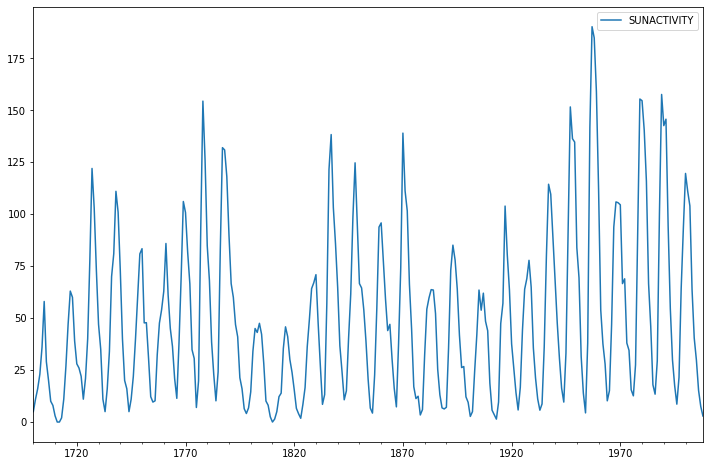

In [2]:
dta = sm.datasets.sunspots.load_pandas().data
dta.index = pd.Index(sm.tsa.datetools.dates_from_range('1700', '2008'))
del dta["YEAR"]
dta.plot(figsize=(12,8))
plt.show()

#### ACF & PACF

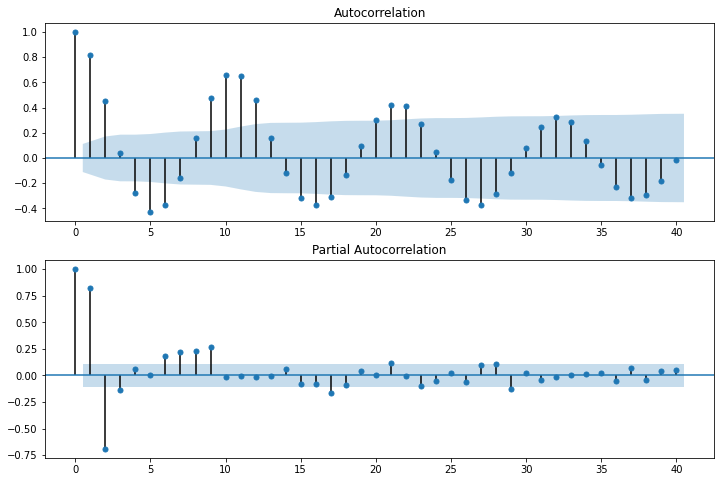

In [3]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(dta.values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(dta, lags=40, ax=ax2)
plt.show()

In [4]:
print (dta)

            SUNACTIVITY
1700-12-31          5.0
1701-12-31         11.0
1702-12-31         16.0
1703-12-31         23.0
1704-12-31         36.0
...                 ...
2004-12-31         40.4
2005-12-31         29.8
2006-12-31         15.2
2007-12-31          7.5
2008-12-31          2.9

[309 rows x 1 columns]


#### Fit AR Model of order p

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency A-DEC will be used.
  % freq, ValueWarning)


const                49.749974
ar.L1.SUNACTIVITY     1.300810
ar.L2.SUNACTIVITY    -0.508093
ar.L3.SUNACTIVITY    -0.129650
dtype: float64
roots obtained with coeffients : [ 0.96896121-0.61485049j  0.96896121+0.61485049j -5.85689079+0.j        ]
roots by the model:  [ 0.96896121-0.61485049j  0.96896121+0.61485049j -5.85689079-0.j        ]


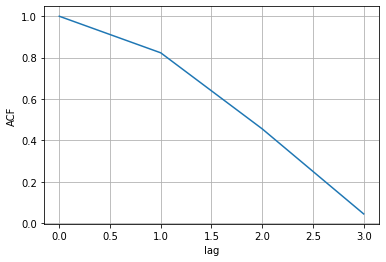

In [5]:
# TODO: chose p appropriately
p = 3
arma_mod = sm.tsa.ARMA(dta, (p,0)).fit(disp=False)
print(arma_mod.params)
c = arma_mod.params['const']
cf = []

for i in range (p):
  cf.append(arma_mod.params['ar.L%d.SUNACTIVITY'%(i+1)])
# TODO: predict ACF of model at lag 0, 1, ..., p
data = dta['SUNACTIVITY']
rho = np.zeros(p+1)
rho[0] =1

P = -np.array([[cf[1]-1, cf[2]], [cf[0]+cf[2], -1]])
rho_1_2 = np.linalg.inv(P).dot(np.array([cf[0], cf[1]]))
rho[1], rho[2] = rho_1_2[0], rho_1_2[1]
rho[p] = cf[0]*rho[p-1] + cf[1]*rho[p-2] + cf[2]*rho[p-3]

plt.plot (rho)
plt.xlabel ('lag')
plt.ylabel ('ACF')
plt.grid() 
# TODO: compute roots
roots = np.zeros(p)
cf = np.array(cf)
cf = np.append(np.array(-1), cf)
roots = np.roots(np.flip(cf))
print ('roots obtained with coeffients :', np.flip(roots))
roots = arma_mod.arroots
print('roots by the model: ', roots)

**Since the roots are outside the unit circle, this process is causal and invertible by definition.**


#### prediction

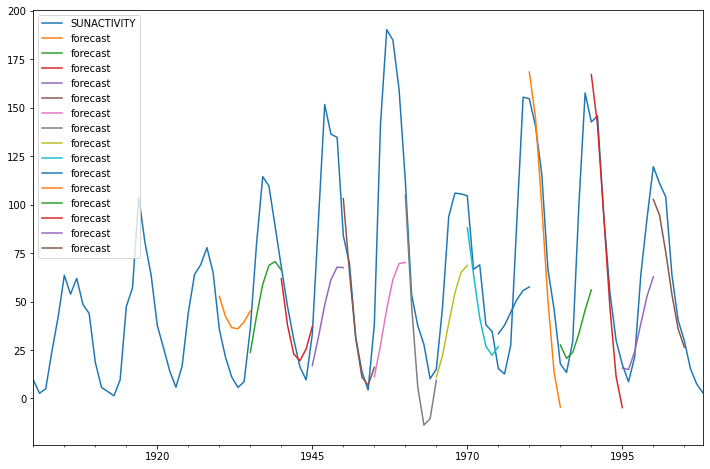

In [7]:
# TODO: try to predict further into the future by increasing tsteps
tsteps= 5

fig, ax = plt.subplots(figsize=(12, 8))
ax = dta.loc['1900':].plot(ax=ax)
T = np.arange(1930, 2010, tsteps)
for tt in range(len(T)-1):
    fig = arma_mod.plot_predict(np.str(T[tt]), np.str(T[tt+1])+np.str("-12-31"), dynamic=True, ax=ax, plot_insample=False)
plt.show()

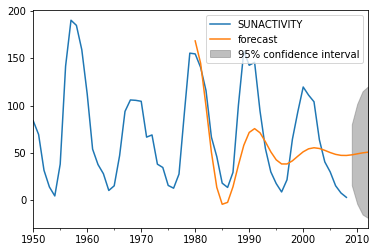

In [8]:
# if problems with above code, use instead:
dta = sm.datasets.sunspots.load_pandas().data[['SUNACTIVITY']]
dta.index = pd.date_range(start='1700', end='2009', freq='A')
res = sm.tsa.ARMA(dta, (p, 0)).fit()
fig, ax = plt.subplots()
ax = dta.loc['1950':].plot(ax=ax)
startyear = '1980'
endyear = '2012'
fig = res.plot_predict(startyear, endyear, dynamic=True, ax=ax,
                       plot_insample=False)

#### plot ACF and PACF

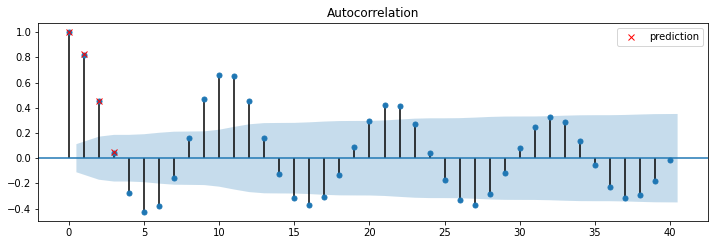

In [9]:
predict_sunspots = arma_mod.predict('1950', '2012', dynamic=True)

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(dta.values.squeeze(), lags=40, ax=ax1)
ax1.plot(np.arange(p+1), rho, 'xr', label='prediction')
ax1.legend()
plt.show()

## Implement AR model from Scratch

### Section I: Implementing the AR Model

Recall that the negative log-likelihood function takes as input the parameter values and returns the negative log probability
of the observed data, under the assumption that those were the parameters used to generate the data.

For an AR(p) model, we have:

$$ NLL(\phi_1, \phi_2, \ldots, \phi_p, \sigma ~; x_1, x_2, \ldots, x_n) = \sum_{t=p+1}^n \left( \log \left( \sigma \sqrt{2 \pi} \right) + \frac{1}{2} \cdot \left( \frac{x_t - \left( \sum\limits_{i=1}^p \phi_i x_{t-i} \right)}{\sigma} \right)^2 \right) $$

Optional: We use Nelder-Mead Algorithm to find the minimum of the loss. Check this link if you're interested (https://machinelearningmastery.com/how-to-use-nelder-mead-optimization-in-python/)

**Variance of error for AR(2) model is computed in the following way**: 
$Error(N) = \sigma^2 \sum_{i=1}^{i=N} A_n^2\\$ 
$A_n = \phi_1A_{n-1} + \phi_2A_{n-2} \\$
$$A_1 = 1,A_2 = \phi_1\\$$ 

In [282]:
class ARModel:
    """Class that implements an ARMA Model. Its functions are as follows:
    1. Maximum Likelihood estimation of parameters
    2. Inference/prediction of future states
    3. Data simulation
    """
    def __init__(self, p, data, p_params = None, sigma = None):
        """Initialize the network state
        @param p: the number of time steps to include in the AR process
        @param p_params: the initialization for the AR parameters
        """
        if (p_params is None):
            p_params = np.zeros(p)
        if (sigma is None):
            sigma = 1
            
        assert p == len(p_params)
        
        #assign parameter values
        self.p = p
        self.p_params = p_params
        self.sigma = sigma
        #store the data within the object
        self.data = data
    
    def loss(self, params):
        """
        params: array of parameters, elements 0:p = p_params, element p = sigma
        returns: loss
        """
        assert len(params) == self.p + 1
        N = self.data.shape[0]
        p_params = params[0:self.p]
        sigma = params[self.p]
        loss = 0
        #TODO: calculate the NLL of the data for the purposes of optimization and store it in loss
        for t in np.arange(self.p, N-1):
          loss += np.log(sigma*np.sqrt(2*np.pi)) + 0.5* ((self.data[t]-np.flip(self.data[t-p:t])@self.p_params)/sigma)**2             
        return loss

    def fit(self):
        # Minimize the loss function, given the dataset
        params = np.concatenate((self.p_params, np.array([self.sigma])))
        res = minimize(self.loss, params, method='nelder-mead',
               options={'xatol': 1e-8, 'disp': True})
        self.p_params = res.x[0:self.p]
        self.sigma = res.x[self.p]
        
    def predict(self,data, N):
        """Method that predicts N timesteps in the future given input data
        @params data: p data points used to form the prediction
        @params N: number of time steps to predict in the future
        
        returns:
        prediction: predicted future value
        conf: variance of the estimated future value
        """

        assert len(data) == self.p
        prediction = np.zeros(N)
        conf = np.zeros(N)
        
        # poly: array to store the coefficients to calculate the variance errors after N time steps
        poly = [] 
        #TODO: predict N time steps in advance, given an input.
        #The inference can be specific to your choice of p, no need to worry about general inference here
        error = 0
        if N == 0:
          return data[-1], 0
        else:
          for i in range (N):
            prediction[i] = self.p_params@np.flip(data[i:self.p+i])
            data = np.append(data, prediction[i])
            if i ==0:
              poly.append(1)
            elif i ==1:
              poly.append(self.p_params[0])
            else:
              poly.append(poly[i-1]*self.p_params[0] + poly[i-2]*self.p_params[1])
        # compute the variance of error for AR(2)
        for i in range (N):
          error += poly[i]**2*self.sigma**2    

        return prediction[-1], error
        
    def simulate(self,N):
        """Method that stimulates data given the p_params and q_params
        @param N: number of datapoints to simulate
        returns: N sampled datapoints
        """
        transient = 100 # length of time to run the simulation to wash out initial conditions
        w_t = self.sigma * np.random.normal(size = (N + transient,))
        x_t = np.zeros(N + transient)
        
        # TODO: generate data x_t given the parameters and white noise w_t
        for i in np.arange(p, N+transient):
          x_t[i] = self.p_params@np.flip(x_t[i-self.p:i]) + w_t[i]
        return x_t[transient::] #discard the transient when returning simulated data    

### Section II: Fitting the AR Model

In this section, we will load some data from an unknown source, look at its ACF and PACF
plots to determine an appropriate AR(p) order, and fit the AR(p) model to the data to determine
the coefficients of the AR model as well as the standard deviation of the driving white noise process.

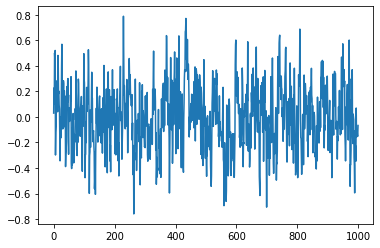

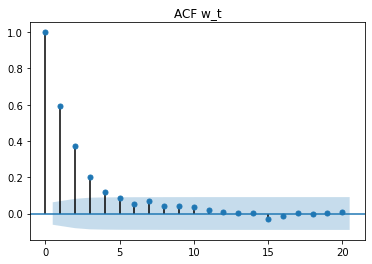

<Figure size 432x288 with 0 Axes>

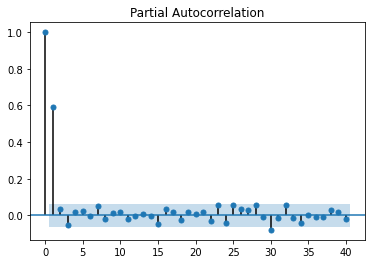

In [283]:
data = np.load("lab_2_data.npy")

#plot the acf of the data
lag = 20
plt.plot(data)
plot_acf(x=data, lags=lag, title="ACF w_t")
plt.show()

#plot the pacf of the data
plt.figure()
sm.graphics.tsa.plot_pacf(data, lags=40)
plt.show()

In [285]:
# fit the model
p = 2 #TODO: choose a 'p' value
rho = acf (data, nlags=20)
#R = np.array([[rho[0], rho[1]],[rho[1],rho[0]]])
R = np.array([[rho[0], rho[1]],
              [rho[1],rho[0]]]
              )
# guess p_parames using acfs, rho(0) and rho(1)
phi_12 = np.linalg.inv(R).dot(np.array([rho[1], rho[2]]).T)

data_fitter = ARModel(p, data, p_params = phi_12, sigma = rho[0]) # set p_params and sigma to an educated guess for parameter values
data_fitter.fit()
print('lambda = ' + str(data_fitter.p_params))
print('sigma = ' + str(data_fitter.sigma))

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in log


Optimization terminated successfully.
         Current function value: -172.329005
         Iterations: 90
         Function evaluations: 184
lambda = [0.68288624 0.04034555]
sigma = 0.20356170853329958


### Section III: Simulating data

Now, we will use our fitted model to simulate a run of the AR model.

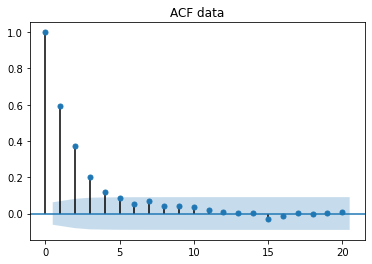

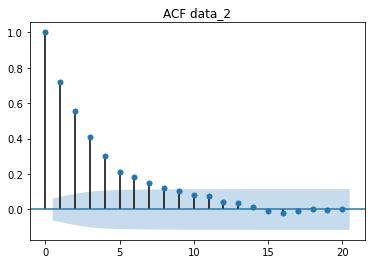

<Figure size 432x288 with 0 Axes>

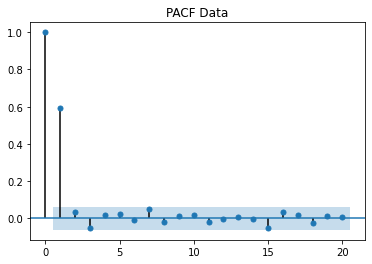

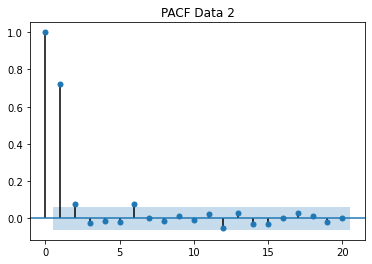

In [288]:
#Generate 1000 samples from the fit model
data_2 = data_fitter.simulate(1000)

#Compare the ACF from the fit model to the data ACF
lag = 20

plot_acf(x=data, lags=lag, title="ACF data")
plot_acf(x=data_2, lags=lag, title="ACF data_2")
plt.show()

#Compare the PACF from the fit model to the data ACF
plt.figure()
sm.graphics.tsa.plot_pacf(data, lags=20)
plt.title('PACF Data')
sm.graphics.tsa.plot_pacf(data_2, lags=20)
plt.title('PACF Data 2')
plt.show()

### Section IV: Using the AR Model for prediction

Finally, we will use some of the provided data as a starting point and predict the next 20 values
based on our AR model's fitted parameters. This will be repeated for each of various starting points.

In [289]:
#for each of the given data points, generate predictions 20 time steps into the future
sample_interval = 200
n_sample = int(len(data)/sample_interval) # number of sample points
data_prediction = data[0:1000:sample_interval]
data_sample = np.zeros(shape = [n_sample, p])
for i , j in enumerate(np.arange(1000, step = sample_interval)):
  data_sample[i] = data[j:j+p]

predictions = np.zeros((len(data_prediction), 20))
mse = np.zeros((len(data_prediction), 20))
for ii in range(0, len(data_prediction)):
    for jj in range(0,20):
        #for each data point, predict for each of 20 time steps
        predictions[ii,jj], mse[ii,jj] = data_fitter.predict(data_sample[ii],jj)


In [280]:
print (mse)

[[0.         0.04143737 0.06076101 0.07139897 0.07718129 0.08032727
  0.08203878 0.0829699  0.08347646 0.08375204 0.08390197 0.08398353
  0.08402791 0.08405205 0.08406518 0.08407233 0.08407621 0.08407833
  0.08407948 0.0840801 ]
 [0.         0.04143737 0.06076101 0.07139897 0.07718129 0.08032727
  0.08203878 0.0829699  0.08347646 0.08375204 0.08390197 0.08398353
  0.08402791 0.08405205 0.08406518 0.08407233 0.08407621 0.08407833
  0.08407948 0.0840801 ]
 [0.         0.04143737 0.06076101 0.07139897 0.07718129 0.08032727
  0.08203878 0.0829699  0.08347646 0.08375204 0.08390197 0.08398353
  0.08402791 0.08405205 0.08406518 0.08407233 0.08407621 0.08407833
  0.08407948 0.0840801 ]
 [0.         0.04143737 0.06076101 0.07139897 0.07718129 0.08032727
  0.08203878 0.0829699  0.08347646 0.08375204 0.08390197 0.08398353
  0.08402791 0.08405205 0.08406518 0.08407233 0.08407621 0.08407833
  0.08407948 0.0840801 ]
 [0.         0.04143737 0.06076101 0.07139897 0.07718129 0.08032727
  0.08203878 0.0

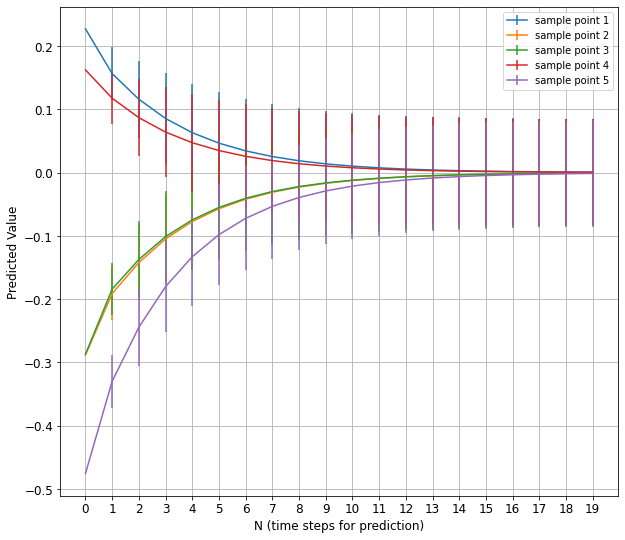

In [290]:
#plot the MSE bars of the estimate
plt.figure(figsize=(10,9))
for ii in range(n_sample):
    plt.errorbar(np.arange(0,20), predictions[ii,:], yerr = mse[ii,:], label = 'sample point %d'%(ii+1))
plt.legend()
plt.grid()
plt.xlabel ('N (time steps for prediction)', fontsize = 12)
plt.ylabel ('Predicted Value', fontsize = 12)
plt.xticks(np.arange(20), fontsize = 12)
plt.yticks (fontsize = 12)
plt.show()